# Using both DoWhy and BCAUSE to solve example 7

In another example we used GCM to solve a version of example 7 in which the confounder variables were observable. In this notebook, we will integrate the BCAUSE library to solve the same problem but this time with latent confounders.

![title](<example7.png>)

In this example, $U_1, U_2, U_3$ won't be included in the dataset, but will have a considerable effect on the endogenous variables.

In [58]:
from dowhy import gcm
from dowhy.utils import plot
from dowhy.gcm.causal_mechanisms import FunctionalCausalModel
from bcause.factors import DeterministicFactor, MultinomialFactor
from bcause.models.cmodel import StructuralCausalModel
from bcause.inference.causal.elimination import CausalVariableElimination
from bcause.inference.causal.multi import EMCC
from bcause.util import randomUtil
from scipy.stats import bernoulli
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import logging
warnings.simplefilter(action='ignore')
logging.getLogger().setLevel(logging.ERROR)

## Creating the model

### Setting the DAG

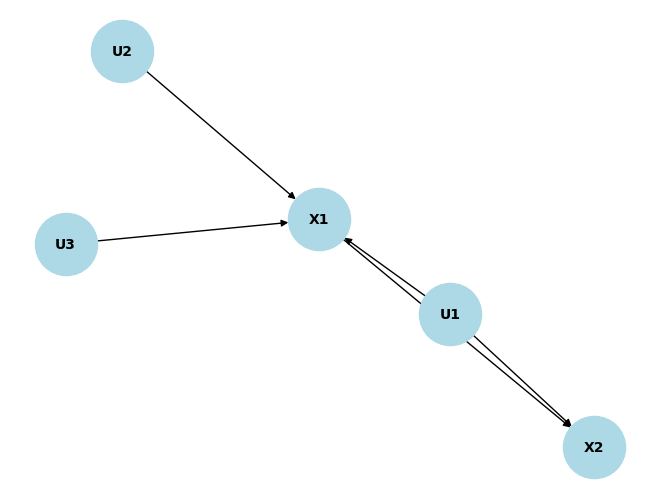

In [2]:
causal_graph = nx.DiGraph([
    ("U1", "X1"),
    ("U2", "X1"),
    ("U3", "X1"),
    ("X1", "X2"),
    ("U1", "X2")
])
causal_model = gcm.StructuralCausalModel(causal_graph)

nx.draw(causal_graph, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
plt.show()

### Setting causal mechanisms

At first, we will assign a binomial distribution with probability $p=0.5$ to each confounder. Later, with the help of BCAUSE, we will overwrite these values.

In [3]:
causal_model.set_causal_mechanism('U1', gcm.ScipyDistribution('binom', n=1, p=0.5))
causal_model.set_causal_mechanism('U2', gcm.ScipyDistribution('binom', n=1, p=0.5))
causal_model.set_causal_mechanism('U3', gcm.ScipyDistribution('binom', n=1, p=0.5))

class X1Model(FunctionalCausalModel):
    def fit(self, X, Y):
        # No parameters to fit for this deterministic function
        pass

    def predict(self, X):
        # Use evaluate and draw_noise_samples to generate predictions
        noise = self.draw_noise_samples(len(X))
        return self.evaluate(X, noise)

    def evaluate(self, X, noise):
        # X[:, 0], X[:, 1], X[:, 2] correspond to U1, U2, U3 respectively
        U1 = X[:, 0]
        U2 = X[:, 1]
        U3 = X[:, 2]
        return np.round(((1 - U1) * U2 * U3 + noise)).astype(int)

    def draw_noise_samples(self, num_samples):
        # Generate noise samples
        return np.random.normal(loc=0, scale=0.0001, size=num_samples)

    def clone(self):
        # Return a new instance of this model
        return X1Model()

class X2Model(FunctionalCausalModel):
    def fit(self, X, Y):
        # No parameters to fit for this deterministic function
        pass

    def predict(self, X):
        # Use evaluate and draw_noise_samples to generate predictions
        noise = self.draw_noise_samples(len(X))
        return self.evaluate(X, noise)

    def evaluate(self, X, noise):
        # X[:, 0], X[:, 1] correspond to X1 and U1 respectively
        X1 = X[:, 0]
        U1 = X[:, 1]
        return np.round((X1 + U1 - X1 * U1 + noise)).astype(int)

    def draw_noise_samples(self, num_samples):
        # Generate noise samples
        return np.random.normal(loc=0, scale=0.0001, size=num_samples)

    def clone(self):
        # Return a new instance of this model
        return X2Model()

# Set custom causal mechanisms for X1 and X2
causal_model.set_causal_mechanism('X1', X1Model())
causal_model.set_causal_mechanism('X2', X2Model())

## Converting the model designed in DoWhy to BCAUSE

We will just use the same DAG defined previously.

In [4]:
dag = causal_graph

Since all variables are binary, they will all present 2 possible values.

In [5]:
domains = dict(X1=["x11", "x22"], X2=["x21","x22"], U1=["u11", "u12"], U2=["u21", "u22"], U3=["u31", "u32"])

Now, to determine the deterministic factors, we will use the models we already defined.

In [6]:
# Define the domains
domains = dict(X1=["x11", "x22"], U1=["u11", "u12"], U2=["u21", "u22"], U3=["u31", "u32"])

# Initialize the list of lists
values_x1 = []

# Define the model
x1_model = X1Model()

# Populate the list of lists based on the conditions
for u1 in domains['U1']:
    for u2 in domains['U2']:
        for u3 in domains['U3']:
            u_values = np.array([[0 if u1[-1] == '1' else 1, 
                                  0 if u2[-1] == '1' else 1, 
                                  0 if u3[-1] == '1' else 1]])
            x1_value = x1_model.evaluate(u_values, x1_model.draw_noise_samples(1))[0]
            values_x1.append(f"x1{x1_value + 1}")

# Print the results
print(values_x1)

['x11', 'x11', 'x11', 'x12', 'x11', 'x11', 'x11', 'x11']


In [7]:
# Define the domains
domains = dict(X1=["x11", "x12"], X2=["x21", "x22"], U1=["u11", "u12"], U2=["u21", "u22"], U3=["u31", "u32"])

# Initialize the list of lists
values_x2 = []

# Define the model
x2_model = X2Model()

# Populate the list of lists based on the conditions
for u1 in domains['U1']:
    for x1 in domains['X1']:
        u_values = np.array([[0 if u1[-1] == '1' else 1, 
                                0 if x1[-1] == '1' else 1]])
        x2_value = x2_model.evaluate(u_values, x2_model.draw_noise_samples(1))[0]
        values_x2.append(f"x2{x2_value + 1}")

# Print the results
print(values_x2)

['x21', 'x22', 'x22', 'x22']


In [8]:
domx1 = {'U1': domains['U1'],  'U2': domains['U2'], 'U3': domains['U3'], 'X1': domains['X1']}
fx1 = DeterministicFactor(domx1, left_vars=['X1'], right_vars=['U1', 'U2', 'U3'], values=values_x1)
print(fx1)

<DeterministicFactor fX1(U1,U2,U3), cardinality = (U1:2,U2:2,U3:2,X1:2), values=[x11,x11,x11,x12,...,x11]>


In [9]:
domx2 = {'U1': domains['U1'], 'X1': domains['X1'], 'X2': domains['X2']}
fx2 = DeterministicFactor(domx2, right_vars=['U1', 'X1'], values=values_x2)
print(fx2)

<DeterministicFactor fX2(U1,X1), cardinality = (U1:2,X1:2,X2:2), values=[x21,x22,x22,x22]>


For the exogenous variables, we will use same $p$ we previously defined, but they will be overwritten in the future anyways.

In [10]:
domu1 =  {"U1": domains["U1"]}
pu1 = MultinomialFactor(domu1, values=[.5, .5])
pu1

<MultinomialFactor P(U1), cardinality = (U1:2), values=[0.5,0.5]>

In [11]:
domu2 =  {"U2": domains["U2"]}
pu2 = MultinomialFactor(domu2, values=[.5, .5])
pu2

<MultinomialFactor P(U2), cardinality = (U2:2), values=[0.5,0.5]>

In [12]:
domu3 =  {"U3": domains["U3"]}
pu3 = MultinomialFactor(domu3, values=[.5, .5])
pu3

<MultinomialFactor P(U3), cardinality = (U3:2), values=[0.5,0.5]>

In [13]:
model = StructuralCausalModel(dag, [fx1, fx2, pu1, pu2, pu3])
model

<StructuralCausalModel (X1:2,X2:2|U1:2,U2:2,U3:2), dag=[U1][X1|U1:U2:U3][U2][U3][X2|X1:U1]>

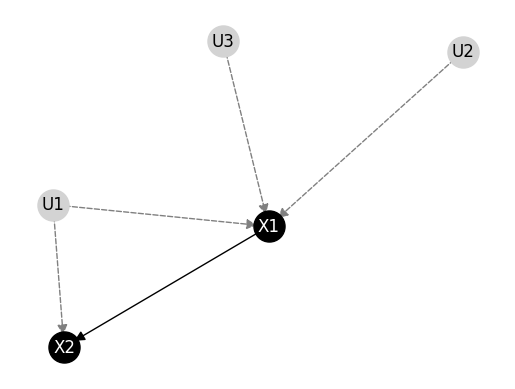

In [14]:
model.draw()

In [15]:
model.endogenous, model.exogenous

(['X1', 'X2'], ['U1', 'U2', 'U3'])

In [16]:
model.factors

{'U1': <MultinomialFactor P(U1), cardinality = (U1:2), values=[0.5,0.5]>,
 'X1': <MultinomialFactor P(X1|U1,U2,U3), cardinality = (U1:2,U2:2,U3:2,X1:2), values=[1.0,0.0,1.0,0.0,...,0.0]>,
 'U2': <MultinomialFactor P(U2), cardinality = (U2:2), values=[0.5,0.5]>,
 'U3': <MultinomialFactor P(U3), cardinality = (U3:2), values=[0.5,0.5]>,
 'X2': <MultinomialFactor P(X2|U1,X1), cardinality = (U1:2,X1:2,X2:2), values=[1.0,0.0,0.0,1.0,...,1.0]>}

We can run queries using the arbitrary probabilities we defined, even without data. 

In [17]:
# Run causal inference with Variable Elimination
cve = CausalVariableElimination(model)
cve.causal_query("X2", do=dict(X1="x12"))

<MultinomialFactor P(X2), cardinality = (X2:2), values=[0.0,1.0]>

In [18]:
# Run a counterfactual query
cve.counterfactual_query("X2",do=dict(X1="x12"), evidence=dict(X1="x11"))

<MultinomialFactor P(X2_1), cardinality = (X2_1:2), values=[0.0,1.0]>

### Generating data

In [19]:
# Number of samples to generate
n_samples = 1000

# Generate U1, U2, U3 as random binary variables (Bernoulli with p=0.5)
U1 = np.random.binomial(1, 0.5, n_samples)
U2 = np.random.binomial(1, 0.5, n_samples)
U3 = np.random.binomial(1, 0.5, n_samples)

# Define X1 and X2 according to the causal mechanisms
X1 = (1 - U1.astype(int)) * U2.astype(int) * U3.astype(int)
X2 = X1 + U1.astype(int) - X1 * U1.astype(int)

# Convert boolean values to integers (0 or 1)
X1 = X1.astype(str)
X2 = X2.astype(str)

for i in range(len(X1)):
    X1[i] = f'x1{int(X1[i])+1}'
    X2[i] = f'x2{int(X2[i])+1}'

# Create a DataFrame to store the dataset
data = pd.DataFrame({
    'X1': X1,
    'X2': X2
})

# Display the first few rows of the dataset
data.head()

,X1,X2
0,x11,x21
1,x11,x22
2,x11,x22
3,x11,x22
4,x11,x21


We can see that the exogenous variables weren't included in the data.

In [20]:
inf = EMCC(model, data, max_iter=100, num_runs=20)

We can now perform all sorts of causal and conterfactual queries.

In [21]:
p = inf.causal_query("X2", do=dict(X1="x12"))
p

<IntervalProbFactor P(X2), cardinality = (X2:2), values_low=[0.0,1.0], values_up=[0.0,1.0]>

In [22]:
p = inf.causal_query("X2", do=dict(X1="x11"))
p

<IntervalProbFactor P(X2), cardinality = (X2:2), values_low=[0.507,0.493], values_up=[0.507,0.493]>

In [23]:
p = inf.counterfactual_query("X2", do=dict(X1="x11"), evidence=dict(X1="x12"))
p

<IntervalProbFactor P(X2_1), cardinality = (X2_1:2), values_low=[1.0,0.0], values_up=[1.0,0.0]>

If we check the factors atribute again, we can see that the probabilities for the exogenous variables were really overwritten.

In [24]:
inf.model.factors

{'U1': <MultinomialFactor P(U1), cardinality = (U1:2), values=[0.507,0.493]>,
 'X1': <MultinomialFactor P(X1|U1,U2,U3), cardinality = (U1:2,U2:2,U3:2,X1:2), values=[1.0,0.0,1.0,0.0,...,0.0]>,
 'U2': <MultinomialFactor P(U2), cardinality = (U2:2), values=[0.44523599886575566,0.5547640011342444]>,
 'U3': <MultinomialFactor P(U3), cardinality = (U3:2), values=[0.5555798087703613,0.4444201912296388]>,
 'X2': <MultinomialFactor P(X2|U1,X1), cardinality = (U1:2,X1:2,X2:2), values=[1.0,0.0,0.0,1.0,...,1.0]>}

### Calculating the ACE

We will now calculate the both the lower and the upper bounds for the ACE:

In [25]:
# Calculate causal query for both interventions
doX11 = inf.causal_query("X2", do=dict(X1="x11"))
doX12 = inf.causal_query("X2", do=dict(X1="x12"))

# Extract values from the dictionaries for both interventions (low bounds)
prob_doX11_low = doX11.store_low.values_dict
prob_doX12_low = doX12.store_low.values_dict

# Extract values from the dictionaries for both interventions (high bounds)
prob_doX11_high = doX11.store_up.values_dict
prob_doX12_high = doX12.store_up.values_dict

# Find the probability values corresponding to 'x22' in each dictionary for store_low
value_doX11_x22_low = prob_doX11_low.get((('X2', 'x22'),), 0)
value_doX12_x22_low = prob_doX12_low.get((('X2', 'x22'),), 0)

# Find the probability values corresponding to 'x22' in each dictionary for store_up
value_doX11_x22_high = prob_doX11_high.get((('X2', 'x22'),), 0)
value_doX12_x22_high = prob_doX12_high.get((('X2', 'x22'),), 0)

# Calculate the ACE bounds using the low and high values
ace_low = value_doX12_x22_low - value_doX11_x22_low
ace_high = value_doX12_x22_high - value_doX11_x22_high

# Print the ACE bounds
print("--------------------")
print(f"{ace_low} <= ACE <= {ace_high}")
print("--------------------")



--------------------
0.507 <= ACE <= 0.507
--------------------


We can observe that:
For $E[X_2|do(X_1 = 1)]$, $X_2$ becomes: 
$$ X_1 \lor U_1 = 1 \lor U_1 = 1 $$
So $E[X_2|do(X_1 = 1)] = 1$.

For $E[X_1|do(X_1 = 1)]$, $X_2$ becomes:
$$ E[X_2|do(X_1 = 0)] = X_1 \lor U_1 = 0 \lor U_1 = U_1 $$
So $X_2$ equals $U_1$, which is a binary variable with $P(U_1=1) = 0.5$.
Therefore:
$$ E[X_2|do(X_1 = 0)] = E[U_1] = (0)(0.5) + (1)(0.5) = 0.5 $$

We can now calculate the ACE:
$$ ACE = E[X_2|do(X_1 = 1)] - E[X_2|do(X_1 = 0)] = 1 - 0.5 = 0.5 $$

Since we found a value close to 0.5, the result can be considered satisfactory.


## Going back to DoWhy

Now we will overwrite the probabilities for the exogenous variables using the ones that were estimated by BCAUSE. 

In [62]:
# Extract the factors from the model
factors = inf.model.factors.values()

# Initialize a list to store the second probability from each factor
second_probabilities = []

# Loop through each factor and extract the second probability
for factor in factors:
    values_list = factor.values  # Access the list of values in the factor
    if len(values_list) == 2:  # Ensure there are at least two values in the list
        second_probabilities.append(values_list[1])

# Print the second probabilities
print(second_probabilities)

causal_model.set_causal_mechanism('U1', gcm.ScipyDistribution(bernoulli, p=second_probabilities[0]))
causal_model.set_causal_mechanism('U2', gcm.ScipyDistribution(bernoulli, p=second_probabilities[1]))
causal_model.set_causal_mechanism('U3', gcm.ScipyDistribution(bernoulli, p=second_probabilities[2]))

[0.493, 0.5547640011342444, 0.4444201912296388]


We can now include $U1, U2, U3$ in the dataset, in a way that allows DoWhy to operate normally.

In [64]:
# Number of samples to generate
n_samples = 1000

# Generate U1, U2, U3 as random binary variables (Bernoulli with p=0.5)
U1 = np.random.binomial(1, second_probabilities[0], n_samples)
U2 = np.random.binomial(1, second_probabilities[1], n_samples)
U3 = np.random.binomial(1, second_probabilities[2], n_samples)

# Define X1 and X2 according to the causal mechanisms
X1 = (1 - U1.astype(int)) * U2.astype(int) * U3.astype(int)
X2 = X1 + U1.astype(int) - X1 * U1.astype(int)

# Convert boolean values to integers (0 or 1)
X1 = X1.astype(int)
X2 = X2.astype(int)

# Create a DataFrame to store the dataset
data = pd.DataFrame({
    'U1': U1,
    'U2': U2,
    'U3': U3,
    'X1': X1,
    'X2': X2
})
data = data.astype(int)

# Display the first few rows of the dataset
print(data.head())

   U1  U2  U3  X1  X2
0   1   1   1   0   1
1   1   1   0   0   1
2   1   1   1   0   1
3   1   1   0   0   1
4   0   1   1   1   1


### Fitting the model

In [65]:
gcm.fit(causal_model, data)
generated_data = gcm.draw_samples(causal_model, num_samples=1000)
print(generated_data.head())

Fitting causal mechanism of node X2: 100%|██████████| 5/5 [00:00<00:00, 1651.95it/s]

   U1  U2  U3  X1  X2
0   0   1   1   1   1
1   1   1   0   0   1
2   1   1   0   0   1
3   0   1   0   0   0
4   1   0   0   0   1


### Calculating the ACE one more time

In [66]:
gcm.average_causal_effect(causal_model,
                         'X2',
                         interventions_alternative={'X1': lambda x: 1},
                         interventions_reference={'X1': lambda x: 0},
                         num_samples_to_draw=1000)

### Estimating confidence intervals (Confidence level = 0.95)

In [67]:
gcm.confidence_intervals(lambda: gcm.average_causal_effect(causal_model,
                         'X2',
                         interventions_alternative={'X1': lambda x: 1},
                         interventions_reference={'X1': lambda x: 0},
                         num_samples_to_draw=1000))

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:00<00:00, 216.25it/s]


(array([0.50865]), array([[0.49045, 0.53405]]))

## Conclusion

As we can see, we're able to translate an input from DoWhy directly into BCAUSE and perform partial identification methods from there. In this notebook, we did every step manually, but we believe it's possible to automate this process in the future.